In [1002]:
import numpy as np
from sklearn.linear_model import Lars
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import scipy.linalg

In [1003]:
X, y = load_diabetes(return_X_y=True)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
y = (y - np.mean(y)) / np.std(y)

# OLS

In [1004]:
b = scipy.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_ols = X.dot(b)
r2_score(y, y_ols)

0.5177494254132934

# Forward stagewise selection

In [981]:
y_forward = np.zeros_like(y)
b = np.zeros(X.shape[1])
bs = [np.zeros_like(b)]

По шажочку

Current correlations: [-1.68, 0.97, 6.61, -0.35, 2.17, 6.29, 1.1, 4.83, -2.49, -0.93]
Selecting 2, c=6.611369226090527
Current r2: 0.5130240377688187


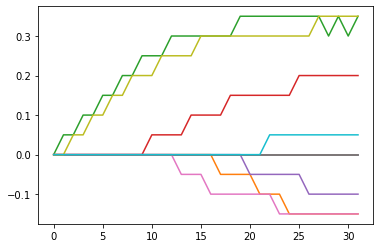

In [972]:
c = X.T.dot(y - y_forward)
print(f'Current correlations: {c.round(2).tolist()}')

j = np.argmax(np.abs(c))
print(f'Selecting {j}, c={c[j]}')
gamma = 0.05 * np.sign(c[j])

b[j] += gamma
bs.append(b.copy())

y_forward = y_forward + gamma * X[:, j]
print(f'Current r2: {r2_score(y, y_forward)}')

plt.plot(np.array(bs))
plt.show()

Быстро

0.5173717755292062


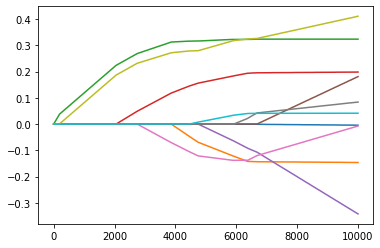

In [982]:
for i in range(10000):
    c = X.T.dot(y - y_forward)

    j = np.argmax(np.abs(c))
    gamma = 0.0002 * np.sign(c[j])

    b[j] += gamma
    bs.append(b.copy())

    y_forward = y_forward + gamma * X[:, j]
print(r2_score(y, y_forward))

plt.plot(np.array(bs))
plt.show()

# Lars

Инициализация

In [983]:
y_lars = np.zeros_like(y)
b = np.zeros(X.shape[1])

j_active = []
j_non_active = list(range(X.shape[1]))

C_hats = []
bs = [np.zeros_like(b)]

Цикл

In [996]:
c = X.T.dot(y - y_lars)
c

array([  42.45074989,   -2.02883655,  123.64918345,  123.64918345,
         26.56333958,   24.89834479, -105.41627298,   98.46989398,
        123.64918345,   92.37099491])

Adding 3 to active sets
Current active set is [2, 8, 3]
Current correlation is 123.64918344565737


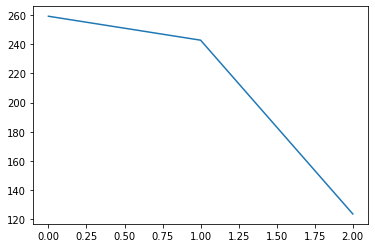

In [997]:
next_index = np.argmax(np.abs(c[j_non_active]))
j = j_non_active[next_index]

print(f'Adding {j} to active sets')
j_active.append(j)
print(f'Current active set is {j_active}')
del j_non_active[next_index]

C_hat = np.max(np.abs(c))
print(f'Current correlation is {C_hat}')
C_hats.append(C_hat)

plt.plot(C_hats)
plt.show()

In [998]:
s = np.sign(c[j_active])

X_a = s * X[:, j_active]

G_a = X_a.T.dot(X_a)

one_a = np.ones(G_a.shape[0])
G_a_inv = scipy.linalg.inv(G_a)
A_a = 1 / np.sqrt(one_a.T.dot(G_a_inv.dot(one_a)))

w_a = A_a * G_a_inv.dot(one_a)
u_a = X_a.dot(w_a)

In [999]:
a = X.T.dot(u_a)
l = (C_hat - c[j_non_active]) / (A_a - a[j_non_active])
r = (C_hat + c[j_non_active]) / (A_a + a[j_non_active])
gammas = np.concatenate((l[l > 0], r[r > 0]))
if len(gammas) == 0:
    print('Thats all folks!')
    gamma = 0
else:
    gamma = np.min(gammas)

In [1000]:
print(f'Making {gamma} step')
y_lars = y_lars + gamma * u_a
b[j_active] += gamma * s * w_a
bs.append(b.copy())

print(f'Current r2: {r2_score(y, y_lars)}, {r2_score(y, X.dot(b))}')

Making 2.2797418658861845 step
Current r2: 0.41733715984472186, 0.41733715984472186


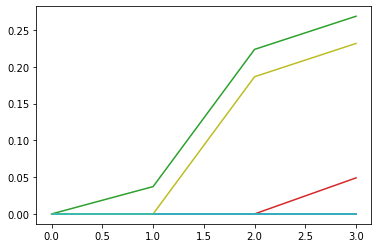

In [1001]:
plt.plot(np.array(bs))
plt.show()